In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Kia.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Capital,Seri_Carens,Seri_Carnival,...,Model_2.9 CRDi Premium,Model_3.5 V6,Model_LS,Model_RS,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,569000,2016,109,1396,87000,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,650000,2022,67,998,6001,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,555000,2020,67,998,38632,1.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,730000,2020,100,1368,6800,0.0,1.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,195000,2003,88,1498,220000,5.0,1.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_2468\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,49270.483399,2.512186e+09,50121.707647,34570.762977


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:14:05,515] A new study created in memory with name: no-name-ee52f4d3-64ae-4fa8-b263-456b125e1299
[I 2023-10-08 14:14:05,743] Trial 1 finished with value: 472685.7969427178 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.08452600192560757, 'max_depth': 8, 'min_child_weight': 225}. Best is trial 1 with value: 472685.7969427178.
[I 2023-10-08 14:14:05,757] Trial 0 finished with value: 98349.81304716096 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.4892070463656984, 'max_depth': 13, 'min_child_weight': 207}. Best is trial 0 with value: 98349.81304716096.
[I 2023-10-08 14:14:05,765] Trial 4 finished with value: 472685.7969427178 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.003730973899456489, 'max_depth': 7, 'min_child_weight': 222}. Best is trial 0 with value: 98349.81304716096.
[I 2023-10-08 14:14:05,782] Trial 5 finished with value: 472685.7969427178 and parameters: {'colsam

[I 2023-10-08 14:14:07,125] Trial 29 finished with value: 113857.53660451517 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.14554498250954467, 'max_depth': 3, 'min_child_weight': 3}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:07,125] Trial 30 finished with value: 108553.41529956213 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.15187308285116946, 'max_depth': 3, 'min_child_weight': 1}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:07,243] Trial 32 finished with value: 193879.68324108058 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.14801024730342008, 'max_depth': 5, 'min_child_weight': 173}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:07,279] Trial 33 finished with value: 345221.53978261276 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.037135909221207755, 'max_depth': 5, 'min_child_weight

[I 2023-10-08 14:14:09,049] Trial 60 finished with value: 81516.20010816572 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.20021346971971288, 'max_depth': 7, 'min_child_weight': 35}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:09,139] Trial 61 finished with value: 55649.27802499876 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.34048834891769675, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:09,232] Trial 62 finished with value: 55141.31879078396 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.34855891758943913, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:09,264] Trial 64 finished with value: 76245.65685113458 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.20309134543431123, 'max_depth': 7, 'min_child_weight': 1

[I 2023-10-08 14:14:11,157] Trial 88 finished with value: 52712.280612448754 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.406181571395219, 'max_depth': 11, 'min_child_weight': 24}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:11,219] Trial 91 finished with value: 53909.43870066036 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3793224735570222, 'max_depth': 14, 'min_child_weight': 23}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:11,345] Trial 92 finished with value: 53338.877651201954 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3991429328627734, 'max_depth': 11, 'min_child_weight': 24}. Best is trial 22 with value: 48440.66747017846.
[I 2023-10-08 14:14:11,480] Trial 93 finished with value: 57303.819933274055 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.49031593894579406, 'max_depth': 11, 'min_child_weight'

[I 2023-10-08 14:14:13,660] Trial 121 finished with value: 67278.0654627615 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.227665683737603, 'max_depth': 14, 'min_child_weight': 30}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:13,684] Trial 120 finished with value: 54406.40131750893 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.41976595155878726, 'max_depth': 14, 'min_child_weight': 29}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:13,708] Trial 122 finished with value: 51400.23944745906 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.42297788814561854, 'max_depth': 14, 'min_child_weight': 19}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:13,788] Trial 123 finished with value: 69142.68475324048 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.23433545481398702, 'max_depth': 14, 'min_child_weigh

[I 2023-10-08 14:14:16,577] Trial 150 finished with value: 49743.47897866041 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.36817811667222117, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:16,632] Trial 151 finished with value: 48866.5657029753 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3564536003286002, 'max_depth': 11, 'min_child_weight': 5}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:16,667] Trial 152 finished with value: 55973.64811703567 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.32740860326968113, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:16,702] Trial 153 finished with value: 50780.676375005416 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3467151690843365, 'max_depth': 11, 'min_child_weight'

[I 2023-10-08 14:14:19,449] Trial 180 finished with value: 51512.137218676566 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.49480589264513003, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:19,875] Trial 181 finished with value: 48855.74248821022 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4334001340911657, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:20,045] Trial 182 finished with value: 49661.29297647427 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.3951512656799322, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:20,092] Trial 183 finished with value: 49628.00583098929 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.41159774032287166, 'max_depth': 12, 'min_child_weight

[I 2023-10-08 14:14:22,849] Trial 212 finished with value: 53142.27595718445 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.41292831772168315, 'max_depth': 13, 'min_child_weight': 21}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:22,911] Trial 211 finished with value: 50441.810620457996 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4202919763719476, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:22,959] Trial 210 finished with value: 47879.66949074874 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.4207757908172705, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:23,078] Trial 213 finished with value: 52112.924851283555 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.40248832054133027, 'max_depth': 12, 'min_child_weig

[I 2023-10-08 14:14:25,691] Trial 238 finished with value: 49390.22529313569 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.48095018633736586, 'max_depth': 11, 'min_child_weight': 9}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:25,835] Trial 241 finished with value: 56583.78737709895 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.4173071435561409, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:26,084] Trial 242 finished with value: 50654.21546197733 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.40952308128345727, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 99 with value: 45171.34250951991.
[I 2023-10-08 14:14:26,100] Trial 244 finished with value: 150395.97613959576 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.4222415513139905, 'max_depth': 11, 'min_child_weight

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 45171.3425
Best params:
	colsample_bytree: 0.7
	subsample: 0.7
	learning_rate: 0.48579340977161356
	max_depth: 12
	min_child_weight: 7


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 56995.26819152002, 'MSE': 2578311512.543291, 'RMSE': 50777.076644321416, 'MAE': 35778.35755208333}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9187452825844146

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8841982088532983

In [16]:
marka_model = joblib.dump(final_model, "Kia.pkl")

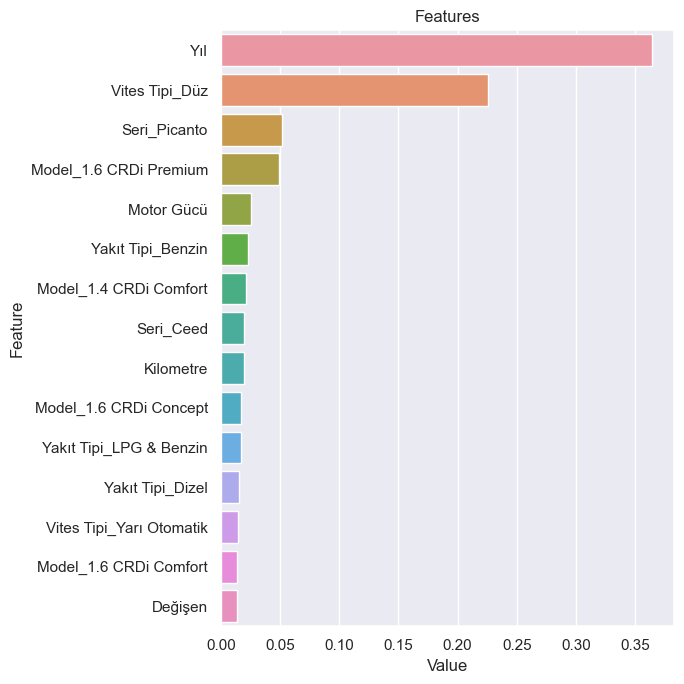

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)